### Model 준비과정

In [1]:
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType
import random
import numpy as np

# 1. 스크립트 최상단에서 랜덤 시드 고정 함수 정의 및 실행
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
    print(f"Random seed set to {seed}")

# 원하는 시드 값으로 설정 (이 숫자를 바꾸지 않는 한 항상 동일하게 초기화됨)
SEED = 42
set_seed(SEED)

# 사용할 모델의 Hugging Face 저장소 이름
model_name = "Qwen/Qwen2.5-Coder-1.5B-Instruct"

Random seed set to 42


In [2]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # 사용 가능한 GPU에 모델을 자동으로 할당합니다.
    torch_dtype=torch.bfloat16,  # 모델을 float16으로 로드합니다.
    trust_remote_code=True,  # 원격 코드 신뢰 설정
)

# 해당 모델에 맞는 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side='left',
    use_fast=True)

print("모델과 토크나이저를 성공적으로 불러왔습니다.")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


모델과 토크나이저를 성공적으로 불러왔습니다.


In [3]:
model.generation_config.temperature = None
model.generation_config.top_p = None
model.generation_config.top_k = None

In [4]:
lora_config = LoraConfig(
    r=8,  # LoRA 행렬의 rank (값이 클수록 파라미터 수가 늘어남)
    lora_alpha=16,  # LoRA 스케일링 alpha (보통 r의 2배)
    # Qwen2 아키텍처의 Attention 관련 레이어를 타겟으로 지정
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
    ],
    lora_dropout=0.0, # Dropout 비율
    bias="none", # bias는 학습하지 않음
    task_type=TaskType.CAUSAL_LM,
)

In [5]:
model.config.use_cache = False
model = get_peft_model(model, lora_config)

# 학습 가능한 파라미터 수 출력 (LoRA의 효율성 확인)
model.print_trainable_parameters()
print("-" * 30)

trainable params: 1,490,944 || all params: 1,545,205,248 || trainable%: 0.0965
------------------------------


### Dataset 준비

In [6]:
import pandas as pd
from datasets import Dataset
from torch.utils.data import DataLoader

In [7]:
from transformers import default_data_collator
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # causal language modeling
)

In [8]:
df = pd.read_excel("data.xlsx")
df["system"] = df["system"].fillna("")  # system 결측값 처리
# 3. Train과 Validation으로 데이터 분할
train_df = df.sample(frac=0.8, random_state=42)  # 80% Train
val_df = df.drop(train_df.index)  # 나머지 20% Validation

def convert_to_chat_format(row):
    return [
        {"role": "system", "content": row["system"]},
        {"role": "user", "content": row["instruction"]},
        {"role": "assistant", "content": row["response"]}
    ]

train_chat_data = [convert_to_chat_format(row) for _, row in train_df.iterrows()]
train_dataset = Dataset.from_dict({"conversations": train_chat_data})

def apply_chat_template_to_dataset(example):
    # conversations 하나씩 처리
    conversation = example["conversations"]
    
    # apply_chat_template 적용
    formatted_text = tokenizer.apply_chat_template(
        conversation,
        tokenize=False,  # 아직 토크나이징하지 않고 텍스트만
        add_generation_prompt=False  # 학습용이므로 generation prompt 불필요
    )
    
    return {"text": formatted_text}

# 채팅 템플릿 적용
formatted_dataset = train_dataset.map(apply_chat_template_to_dataset)

def tokenize_function(examples):
    # 이제 formatted_text들을 실제로 토크나이징
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
        max_length=512,  # 필요에 따라 조정
        return_tensors=None
    )
    
    # labels는 input_ids와 동일하게 설정
    tokenized["labels"] = tokenized["input_ids"]
    
    return tokenized

# 토크나이징 적용
tokenized_dataset = formatted_dataset.map(
    tokenize_function,
    batched=True,  # 배치 단위로 처리 (더 효율적)
    remove_columns=formatted_dataset.column_names  # 기존 컬럼들 제거 (text 컬럼 등)
)

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=data_collator 
)

In [10]:
def create_metric_format(row):
    return {
        "input": [
            {"role": "system", "content": row["system"]},
            {"role": "user", "content": row["instruction"]}
        ],
        "target": row["response"]  # 정답 assistant 응답
    }

val_chat_data = [convert_to_chat_format(row) for _, row in val_df.iterrows()]
val_dataset = Dataset.from_dict({"conversations": val_chat_data})

val_metric_data = [create_metric_format(row) for _, row in val_df.iterrows()]
val_metric_dataset = Dataset.from_dict({
    "input": [item["input"] for item in val_metric_data],
    "target": [item["target"] for item in val_metric_data]
})


# 채팅 템플릿 적용
val_formatted_dataset = val_dataset.map(apply_chat_template_to_dataset)

# 토크나이징 적용
val_tokenized_dataset = val_formatted_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=val_formatted_dataset.column_names
)

# Validation DataLoader 생성
val_loader = DataLoader(
    val_tokenized_dataset,
    batch_size=2,
    shuffle=False,  # validation은 섞지 않음
    num_workers=2,
    pin_memory=True,
    collate_fn=data_collator
)

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

In [11]:
# import evaluate
# rouge = evaluate.load('rouge')

### 학습 준비

In [12]:
cnt = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        cnt += 1
        print(f"{name} - {param.shape}")
print(f"Total trainable parameters: {cnt}")

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight - torch.Size([8, 1536])
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight - torch.Size([1536, 8])
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight - torch.Size([8, 1536])
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight - torch.Size([256, 8])
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight - torch.Size([8, 1536])
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight - torch.Size([256, 8])
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight - torch.Size([8, 1536])
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight - torch.Size([1536, 8])
base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight - torch.Size([8, 1536])
base_model.model.model.layers.1.self_attn.k_proj.lora_B.default.weight - torch.Size([256, 8])
base_model.model.model.layers.1.self_attn.v_proj.lora

In [13]:
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

In [14]:
BASE_LR = 1e-5
MAX_STEPS = 500
EVAL_STEPS = 25

In [15]:
trainable_params = [p for p in model.parameters() if p.requires_grad]
param_groups = [{"params": [p]} for p in trainable_params]
optimizer = AdamW(param_groups, lr=BASE_LR)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=MAX_STEPS)

In [16]:
from tqdm import tqdm

history = {
    "steps": [],
    "train_loss": [],
    "val_loss": [],
    }

global_step = 0

model.train()
progress_bar = tqdm(total=MAX_STEPS, desc="Overall Training Progress")

while global_step < MAX_STEPS:
    for batch_idx, batch in enumerate(train_loader):
        if global_step >= MAX_STEPS:
            break

        batch = {k: v.to(model.device) for k, v in batch.items()}

        # 1. forward
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # 2. optimizer step
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        global_step += 1
        progress_bar.update(1)

        # 3. 정해진 스텝마다 평가
        if global_step % EVAL_STEPS == 0:
            avg_train_loss = loss.item()
            history["steps"].append(global_step)
            history["train_loss"].append(avg_train_loss)

            # --- Validation Loss calculation ---
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in val_loader:
                    val_batch = {k: v.to(model.device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)

            progress_bar.set_postfix(
                train_loss=f"{avg_train_loss:.4f}",
                val_loss=f"{avg_val_loss:.4f}",
            )

            model.train()

progress_bar.close()

Overall Training Progress: 100%|██████████| 500/500 [16:32<00:00,  1.99s/it, train_loss=1.9682, val_loss=1.9139] 


In [17]:
import joblib
joblib.dump(history, "temp/training_history_cosine.pkl")

['temp/training_history_cosine.pkl']

In [18]:
# model.push_to_hub('kyu5787/robot_task_planning')

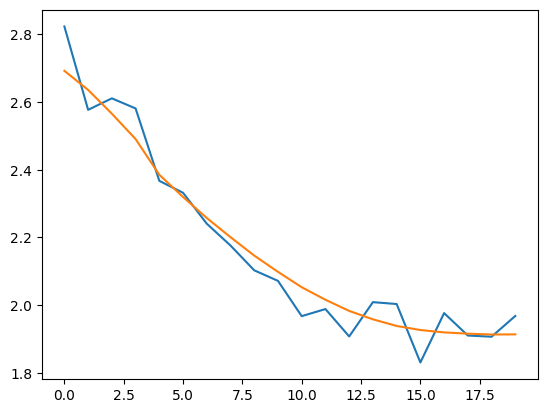

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

In [20]:
import evaluate
rouge = evaluate.load('rouge')

In [21]:
val_preds, val_refs = [], []

for item in tqdm(val_metric_dataset):
    chat_prompt = tokenizer.apply_chat_template(
        item['input'],
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = tokenizer(chat_prompt, return_tensors='pt').to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    if "assistant\n" in generated_text:
        pred = generated_text.split("assistant\n", 1)[1].strip()
    else:
        pred = generated_text.strip()  # fallback
    
    val_preds.append(pred)
    val_refs.append(item['target'])

100%|██████████| 197/197 [04:48<00:00,  1.46s/it]


In [22]:
for i, (val_pred, val_ref) in enumerate(zip(val_preds, val_refs)):
    print(f'{i} th val pred:', val_pred)
    print(f'{i} th val ref:', val_ref)

0 th val pred: [0, 0, 0] = detect('keyboard')
0 th val ref: coords = detect('keyboard')
move_to(coords)
1 th val pred: [0.0, 0.0, 1.0], [0.0, 0.0, 2.0]
1 th val ref: coords = detect('pen')
pick_up(coords)
coords = [coords[0] - 5, coords[1], coords[2]]
place(coords)
2 th val pred: [0.5, 0.0, 0.0] = detect('object')
move_to([0.0, 0.0, 0.5])
change_movement_speed(40)
2 th val ref: change_movement_speed(40)
coords = check_current_pose()
coords = [coords[0], coords[1], coords[2]+0.5]
move_to(coords)
change_movement_speed(100)
3 th val pred: change_movement_speed(45)
3 th val ref: change_movement_speed(45)
4 th val pred: [0.5, 1.0, 2.0] = detect('box')
rotate_screwer([0.5, 1.0, 2.0])
move_to([0.5, 1.0, 3.0])
pick_up([0.5, 1.0, 3.0])
place([0.5, 1.0, 4.0])
4 th val ref: coords = detect('box')
pick_up(coords)
coords_shelf = detect('top shelf')
place(coords_shelf)
5 th val pred: [0, 0, 1] = detect('table')
[0, 0, 2] = detect('wall')
distance = abs(0 - 2)
print(distance)
5 th val ref: coords_tab

In [25]:
rouge_scores = rouge.compute(
    predictions=val_preds,
    references=val_refs,
    use_stemmer=True
)

In [26]:
rouge_scores

{'rouge1': np.float64(0.2095366259315898),
 'rouge2': np.float64(0.09974649211433884),
 'rougeL': np.float64(0.18851607400784096),
 'rougeLsum': np.float64(0.20324492399778302)}